# PeakWeather Demo

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from peakweather import PeakWeatherDataset

## Loading the data

To get the dataset, simply initialize a `PeakWeatherDataset` object. This will, by default, download the data in the current working directory, unless it was previously downloaded.

In [ ]:
dataset = PeakWeatherDataset()

With `get_observations` you can load the timeseries data as a dataframe or array. It is possible to only load spatial and temporal subsets and obtain a binary mask that determined the availability of each measurement. 

In [4]:
df, mask = dataset.get_observations(
    stations=['ABO', 'GRO'],                   # list of stations
    parameters=['temperature', 'wind_speed'],  # list of weather parameters
    first_date='2024-08-02 16:32',
    last_date='2024-08-06 23:26',
    return_mask=True
)

df.head(5)

nat_abbr                          ABO                    GRO           
name                      temperature wind_speed temperature wind_speed
datetime                                                               
2024-08-02 16:40:00+00:00   19.400000        2.0   24.100000        0.8
2024-08-02 16:50:00+00:00   19.600000        2.7   23.100000        0.9
2024-08-02 17:00:00+00:00   19.200001        2.0   22.900000        1.4
2024-08-02 17:10:00+00:00   19.000000        0.9   23.000000        2.3
2024-08-02 17:20:00+00:00   19.100000        1.5   22.799999        2.3

In [5]:
mask.head()

nat_abbr                          ABO                    GRO           
name                      temperature wind_speed temperature wind_speed
datetime                                                               
2024-08-02 16:40:00+00:00        True       True        True       True
2024-08-02 16:50:00+00:00        True       True        True       True
2024-08-02 17:00:00+00:00        True       True        True       True
2024-08-02 17:10:00+00:00        True       True        True       True
2024-08-02 17:20:00+00:00        True       True        True       True

## Visualization of the data

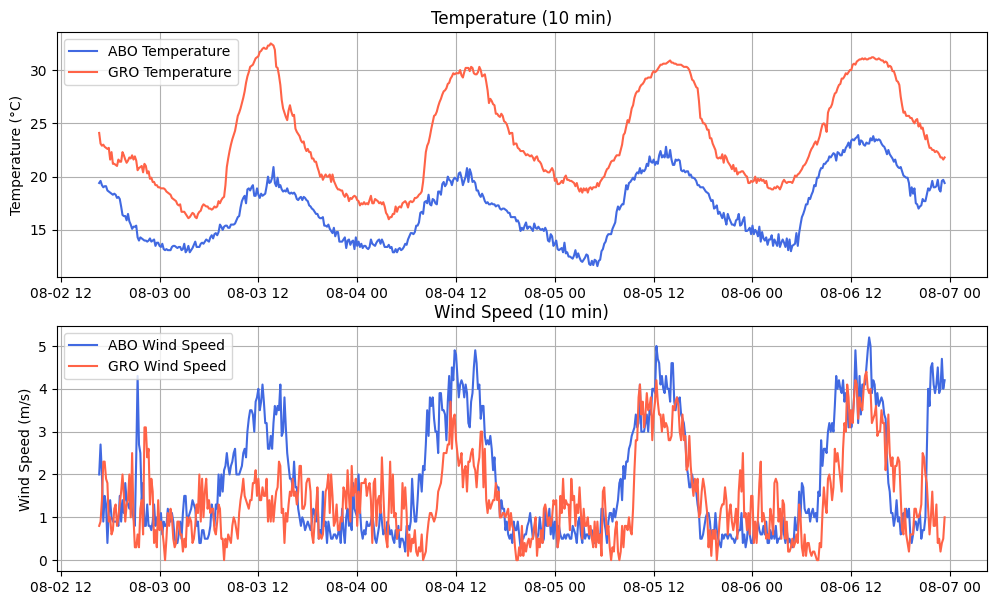

In [6]:
fig, ax = plt.subplots(2, figsize=(12,7))

# Plot temperature
ax[0].plot(df.index, df['ABO', 'temperature'], label='ABO Temperature', color='royalblue')
ax[0].plot(df.index, df['GRO', 'temperature'], label='GRO Temperature', color='tomato')
ax[0].set_title('Temperature (10 min)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

# Plot wind speed
ax[1].plot(df.index, df['ABO', 'wind_speed'], label='ABO Wind Speed', color='royalblue')
ax[1].plot(df.index, df['GRO', 'wind_speed'], label='GRO Wind Speed', color='tomato')
ax[1].set_title('Wind Speed (10 min)')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[1].legend()
ax[1].grid(True)

plt.show()

## Time series windowing

The `get_windows` function extracts sliding windows from the time series using a look-back window `w` and forecast horizon `h`.
This prepares the data in a format that's easy to use with framework-specific datasets and data loaders (e.g., PyTorch, TensorFlow, JAX).

This returns arrays of shape `[n_w, w, n_s, n_f]` for the inputs `x` and `[n_w, h, n_s, n_f]` for the outputs `y`, where `n_w` is the number of windows (or examples/samples), `n_s` is the number of stations and `n_f` is the number of features.

In [7]:
windows = dataset.get_windows(
    window_size=24,  # number of lookback time steps
    horizon_size=6,  # number of lead times to be predicted
    parameters=['temperature', 'wind_speed', 'humidity'],
    stations=['ABO', 'KLO', 'GRO', 'LUG']
)

# [num_windows, num_time_steps, num_stations, num_parameters]
print(f"Windows x shape: \t{windows.x.shape}")
print(f"Windows mask_x shape: \t{windows.mask_x.shape}")
print(f"Windows y shape: \t{windows.y.shape}")
print(f"Windows mask_y shape: \t{windows.mask_y.shape}")

Windows x shape: 	(461923, 24, 4, 3)
Windows mask_x shape: 	(461923, 24, 4, 3)
Windows y shape: 	(461923, 6, 4, 3)
Windows mask_y shape: 	(461923, 6, 4, 3)


## Temporal re-sampling and NWP forecasts

We can initialize the dataset to resample the time series to a coarser frequency, such as from the default **10-minute** interval to **hourly**. 
This is useful for reducing the variability of highly dynamic parameters like wind speed, aligning with lower temporal resolutions, or shortening sequence length for training.

Hourly data also allows us comparing with the forecasts from the numerical weather prediction (NWP) model, which are provided as hourly forecasts within PeakWeather.

Each parameter has a default aggregation method used during temporal resampling, which can be overridden using the `aggregation_method` parameter.

In [ ]:
dataset = PeakWeatherDataset(
    freq='h',
    aggregation_methods={'temperature': 'mean',
                         'wind_gust': 'max'},
    extended_nwp_pars=['temperature', 'wind_u', 'wind_v']
)

Just like before, let's look that temperature and wind speed for the stations of *Adelboden* and *Grono*, this time with an hourly temporal resolution.

In [17]:
df, mask = dataset.get_observations(
    stations=['ABO', 'GRO'],
    parameters=['temperature', 'wind_speed'],
    first_date='2024-08-02 16:32',
    last_date='2024-08-06 23:26',
    return_mask=True
)

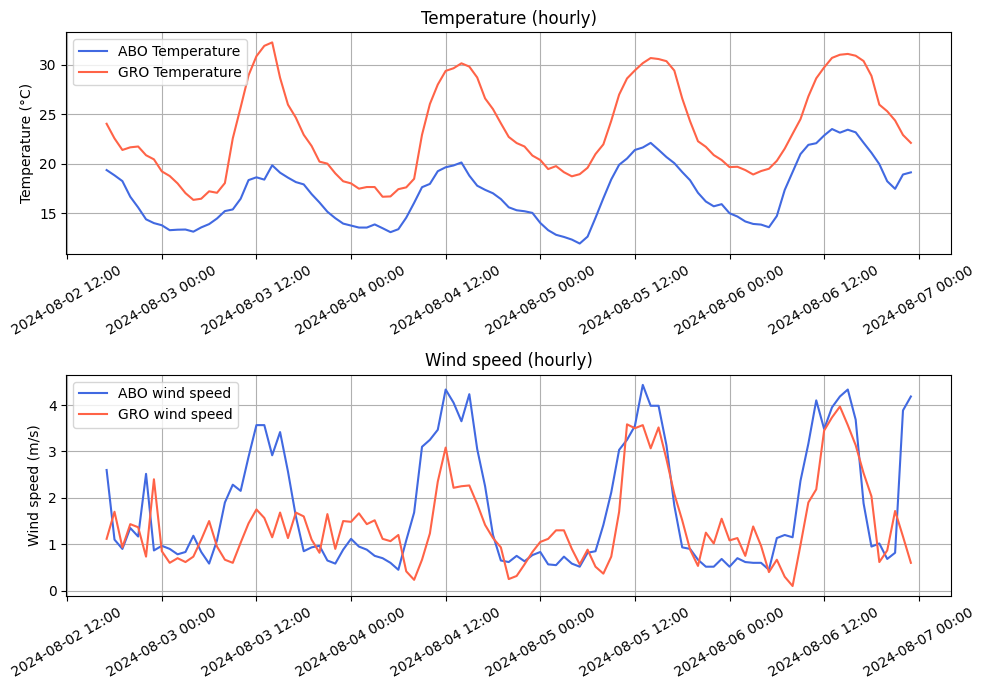

In [18]:
fig, ax = plt.subplots(2, figsize=(10, 7))

# Plot temperature
ax[0].plot(df.index, df['ABO', 'temperature'], label='ABO Temperature', color='royalblue')
ax[0].plot(df.index, df['GRO', 'temperature'], label='GRO Temperature', color='tomato')
ax[0].set_title('Temperature (hourly)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df.index, df['ABO', 'wind_speed'], label='ABO wind speed', color='royalblue')
ax[1].plot(df.index, df['GRO', 'wind_speed'], label='GRO wind speed', color='tomato')
ax[1].set_title('Wind speed (hourly)')
ax[1].set_ylabel('Wind speed (m/s)')
ax[1].legend()
ax[1].grid(True)

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[0].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[0].tick_params(axis='x', rotation=30)

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

Let's now compare data from the stations with forecasts from the NWP model.
The ICON-CH1-EPS NWP model produces 11 ensemble members for an horizon of up to 33 hours ahead. The NWP model is initialized every 3 hours and by setting `split="nwp_test"`, we can generate a subset of the test set with the windows aligned to the NWP model.

Other options are `split="train"` or `split="test"`. In those cases, only observations windows will be produced, with a time delta between them that depends on the selected dataset frequency.

In [19]:
windows = dataset.get_windows(
    window_size=24,  # number of lookback time steps
    horizon_size=24,  # number of lead times to be predicted
    stations=['KLO', 'ABO'],
    split="nwp_test",
    parameters=["temperature", "wind_u", "wind_v"],
    nwp_parameters=['temperature', 'wind_u', 'wind_v'],
    drop_extra_y_pars=False
)

In [26]:
# [num_windows, num_time_steps, num_stations, num_parameters]
print(f"""
Observations x shape:       \t{windows.x.shape}
Observations mask_x shape:  \t{windows.mask_x.shape}
Observations index_x shape: \t{windows.index_x.shape}
Observations y shape:       \t{windows.y.shape}
Observations mask_y shape:  \t{windows.mask_y.shape}
Observations index_y shape: \t{windows.index_y.shape}\n
""")

# [num_windows, num_time_steps, num_stations, num_parameters, num_ensemble_members]

print(f"NWP model fcasts shape:    \t{windows.nwp.shape}\n")

print(f"""
{windows.x.shape[0]}\tNumber of windows
{windows.x.shape[1]}\tLookback window size
{windows.y.shape[1]}\tLead times to predict
{windows.x.shape[2]}\tNumber of considered stations
{windows.x.shape[3]}\tNumber of observed parameters
{windows.nwp.shape[3]}\tNumber of NWP forecasted parameters
{windows.nwp.shape[-1]}\tNumber of NWP ensemble members\n
""")

print(f"{(windows.index_x[1][0] - windows.index_x[0][0]).total_seconds() / 3600}h\t Time delta between windows")


Observations x shape:       	(3003, 24, 2, 3)
Observations mask_x shape:  	(3003, 24, 2, 3)
Observations index_x shape: 	(3003, 24)
Observations y shape:       	(3003, 24, 2, 3)
Observations mask_y shape:  	(3003, 24, 2, 3)
Observations index_y shape: 	(3003, 24)


NWP model fcasts shape:    	(11, 3003, 24, 2, 3)


3003	Number of windows
24	Lookback window size
24	Lead times to predict
2	Number of considered stations
3	Number of observed parameters
2	Number of NWP forecasted parameters
3	Number of NWP ensemble members


3.0h	 Time delta between windows


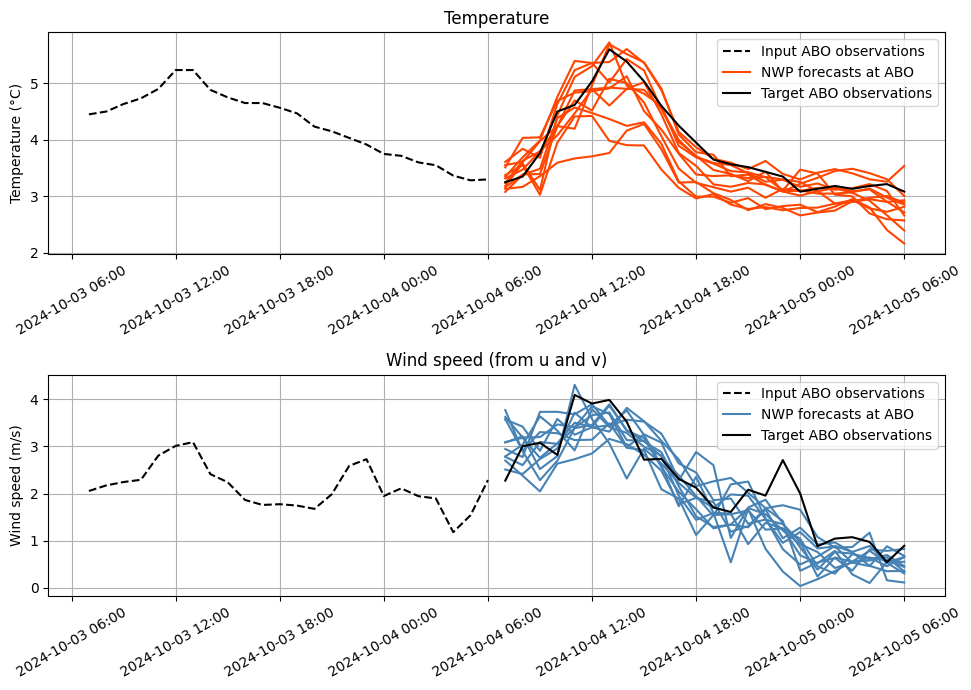

In [91]:
fig, ax = plt.subplots(2, figsize=(10, 7))

w = 18
station = 1
index_to_station = {0: 'KLO', 1: 'ABO'}
# Plot temperature
ax[0].plot(windows.index_x[w], windows.x[w, :, station, 0],
           label=f'Input {index_to_station[station]} observations', color='black', linestyle="dashed")

for ens_member in range(windows.nwp.shape[0]):
    if ens_member == 0:
        ax[0].plot(windows.index_y[w], windows.nwp[ens_member, w, :, station, 0],
                   label=f"NWP forecasts at {index_to_station[station]}", color='orangered')
    else:
        ax[0].plot(windows.index_y[w], windows.nwp[ens_member, w, :, station, 0], color='orangered')

ax[0].plot(windows.index_y[w], windows.y[w, :, station, 0],
           label=f'Target {index_to_station[station]} observations', color='black')
ax[0].set_title('Temperature')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[0].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[0].tick_params(axis='x', rotation=30)
ax[0].grid(True)

# Plot wind speed from u and v componented (eastward and northward)
ax[1].plot(windows.index_x[w], dataset.get_wind_speed(u=windows.x[w, :, station, 1], v=windows.x[w, :, station, 2]),
           label=f'Input {index_to_station[station]} observations', color='black', linestyle="dashed")

for ens_member in range(windows.nwp.shape[0]):
    nwp_wind_speed = dataset.get_wind_speed(u=windows.nwp[...,1], v=windows.nwp[...,2])
    if ens_member == 0:
        ax[1].plot(windows.index_y[w], nwp_wind_speed[ens_member, w, :, station],
                   label=f"NWP forecasts at {index_to_station[station]}", color='steelblue')
    else:
        ax[1].plot(windows.index_y[w], nwp_wind_speed[ens_member, w, :, station],
                   color='steelblue')

ax[1].plot(windows.index_y[w], dataset.get_wind_speed(u=windows.y[w, :, station, 1], v=windows.y[w, :, station, 2]),
           label=f'Target {index_to_station[station]} observations', color='black')
ax[1].set_title('Wind speed (from u and v)')
ax[1].set_ylabel('Wind speed (m/s)')
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[1].tick_params(axis='x', rotation=30)
ax[1].grid(True)

plt.tight_layout()
plt.show()

PeakWeather can also output sliding windows as `Xarray` datasets, allowing the data to remain tightly coupled with its coordinates for easier indexing and analysis.

In [94]:
icon_windows = dataset.get_windows(
    window_size=24,
    horizon_size=24,
    stations=['KLO', 'ABO'],
    split="nwp_test",
    parameters=["temperature", "wind_u", "wind_v"],
    nwp_parameters=["temperature", "wind_u", "wind_v"],
    as_xarray=True
).nwp

icon_windows

<xarray.Dataset> Size: 19MB
Dimensions:      (reftime: 3003, lead: 24, nat_abbr: 2, realization: 11)
Coordinates:
  * reftime      (reftime) datetime64[ns] 24kB 2024-10-02 ... 2025-10-13
  * lead         (lead) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
  * nat_abbr     (nat_abbr) <U5 40B 'KLO' 'ABO'
  * realization  (realization) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    temperature  (reftime, lead, nat_abbr, realization) float32 6MB 12.39 ......
    wind_u       (reftime, lead, nat_abbr, realization) float32 6MB 0.1056 .....
    wind_v       (reftime, lead, nat_abbr, realization) float32 6MB 0.9805 .....
Attributes:
    LICENSE:    CC-BY-4.0
    parameter:  Air temperature, Eastward wind, Northward wind.
    period:     2017-01-01:2025-10-13
    source:     MeteoSwiss (ICON-CH1-EPS)
    time_zone:  UTC

## Static attributes

Each station is either a `rain_gauge`, which measures precipitation (and sometimes temperature), or a `meteo_station` station, which records multiple weather parameters. Every station has a known geographic location, an elevation above sea level, and additional static attributes derived from topographic data interpolated to its position.

The full topographic features at a $50m$ resolution can be loaded by initializing the `PeakWeatherDataset` dataset with the `extended_topo_vars` parameter.

In [95]:
dataset.stations_table

,station_name,latitude,longitude,station_height,swiss_easting,swiss_northing,ASPECT_2000M_SIGRATIO1,WE_DERIVATIVE_2000M_SIGRATIO1,TPI_2000M,SN_DERIVATIVE_10000M_SIGRATIO1,dem,SN_DERIVATIVE_2000M_SIGRATIO1,SLOPE_10000M_SIGRATIO1,ASPECT_10000M_SIGRATIO1,SLOPE_2000M_SIGRATIO1,STD_2000M,STD_10000M,TPI_10000M,WE_DERIVATIVE_10000M_SIGRATIO1,station_type
nat_abbr,,,,,,,,,,,,,,,,,,,,
ABE,Aarberg,47.057969,7.285350,444.00,2.588355e+06,1.211894e+06,310.688416,0.010961,-6.219757,-0.011349,442.315613,-0.009424,0.872107,318.209137,0.828149,0.000000,44.313626,-38.296173,0.010144,rain_gauge
ABO,Adelboden,46.491703,7.560703,1321.38,2.609372e+06,1.148939e+06,124.863129,-0.167379,-53.303345,-0.026807,1317.771851,0.116605,1.702339,25.582031,11.529667,120.940262,374.830623,-443.723877,-0.012833,meteo_station
AEG,Oberägeri,47.133636,8.608206,724.43,2.688729e+06,1.220956e+06,190.899567,0.010865,-20.030273,-0.013760,724.173462,0.056423,1.099379,315.811829,3.288559,27.269887,141.396220,-165.792114,0.013376,meteo_station
AFI,Andelfingen,47.604669,8.670289,360.00,2.692617e+06,1.273392e+06,193.235062,0.004745,-12.622437,-0.001833,357.506256,0.020173,0.299592,290.519653,1.187198,0.000000,31.905980,-55.071655,0.004897,rain_gauge
AGATT,Attelwil,47.265233,8.050519,475.00,2.646308e+06,1.235106e+06,96.557785,-0.020930,-14.010315,-0.009250,474.737488,0.002406,0.593415,333.268860,1.206895,0.000000,75.500339,-105.056763,0.004659,rain_gauge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WYN,Wynau,47.255025,7.787475,421.99,2.626406e+06,1.233849e+06,319.106384,0.021612,-16.944305,-0.002912,421.595306,-0.024955,0.167600,5.381668,1.890799,19.067440,16.002325,-33.209930,-0.000274,meteo_station
ZER,Zermatt,46.029272,7.752433,1638.35,2.624297e+06,1.097574e+06,126.072998,-0.222615,-173.187622,0.023503,1645.671875,0.162173,2.437473,123.514168,15.398737,213.252085,469.596215,-791.969727,-0.035491,meteo_station
ZEV,Zervreila,46.578797,9.118797,1738.00,2.728781e+06,1.159992e+06,109.527702,-0.111410,-240.550537,-0.028125,1738.876587,0.039513,2.217149,43.410706,6.741610,146.893540,324.236704,-571.910034,-0.026606,rain_gauge
